# **MSA Phase 2 - Part 2**

In [1]:
# !pip install pmdarima

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from pmdarima.arima import auto_arima

In [3]:
# # Only on Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **0. Task**


---


In this notebook, I plan to predict the weekly sales for **selected store and department**. In specific, the idea is pick one store and one department, predict its weekly sales for the following couple weeks.

### **1. Load and Examine the Cleaned Dataset**


---



In [4]:
# Path: dataw/cleaned.csv

# --------- Comment Out One Line Below --------- #
# data = pd.read_csv("azureml://")  # For Azure
# data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataw/cleaned.csv")  # For Google Colab
data = pd.read_csv("dataw/cleaned.csv")   # For Local PC
# --------- Comment Out One Line Above --------- #

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Drop extra column
data = data.drop("Unnamed: 0", axis=1)
data.head()

,Store,Dept,Date,Year,Month,Day,IsHoliday,IsHoliday_False,IsHoliday_True,Temperature,CPI,Unemployment,Size,Weekly_Sales
0,1,1,2010-02-05,2010,2,5,0,1,0,42.31,211.096358,8.106,151315,24924.50
1,1,1,2010-02-12,2010,2,12,1,0,1,38.51,211.242170,8.106,151315,46039.49
2,1,1,2010-02-19,2010,2,19,0,1,0,39.93,211.289143,8.106,151315,41595.55
3,1,1,2010-02-26,2010,2,26,0,1,0,46.63,211.319643,8.106,151315,19403.54
4,1,1,2010-03-05,2010,3,5,0,1,0,46.50,211.350143,8.106,151315,21827.90


In [5]:
# Check how many stores
unq_store = len(data["Store"].unique())
print(f"Number of Unique Stores: {unq_store}")

# Check how many days
unq_date = len(data["Date"].unique())
print(f"Number of Unique Dates: {unq_date}")

# Check how many sizes
unq_size = len(data["Size"].unique())
print(f"Number of Unique Sizes: {unq_size}")

Number of Unique Stores: 45
Number of Unique Dates: 143
Number of Unique Sizes: 40


In [6]:
# Check how many departments for each store
n_dept_ls = []
for i in range(1, unq_store+1):
    n_dept = len(data[data["Store"] == i].Dept.unique())
    n_dept_ls.append(n_dept)
    print(f"For Store {i}, there are {n_dept} Departments.")
print("-----------------")
print(f"Min number of Departments: {min(n_dept_ls)}, Max number of Departments: {max(n_dept_ls)}")

For Store 1, there are 77 Departments.
For Store 2, there are 78 Departments.
For Store 3, there are 72 Departments.
For Store 4, there are 78 Departments.
For Store 5, there are 72 Departments.
For Store 6, there are 77 Departments.
For Store 7, there are 76 Departments.
For Store 8, there are 76 Departments.
For Store 9, there are 73 Departments.
For Store 10, there are 77 Departments.
For Store 11, there are 78 Departments.
For Store 12, there are 71 Departments.
For Store 13, there are 79 Departments.
For Store 14, there are 77 Departments.
For Store 15, there are 79 Departments.
For Store 16, there are 76 Departments.
For Store 17, there are 76 Departments.
For Store 18, there are 78 Departments.
For Store 19, there are 79 Departments.
For Store 20, there are 78 Departments.
For Store 21, there are 77 Departments.
For Store 22, there are 76 Departments.
For Store 23, there are 76 Departments.
For Store 24, there are 77 Departments.
For Store 25, there are 77 Departments.
For Store

- The cleaned dataset contains 389387 records for different stores at different dates.
- All features are in numerical datatype except the Date as datetime.
- There are 14 predictors including date-related features as well as temperature, cpi, unemployment, and size.
- There are 45 unique stores in 40 different sizes, and the records are distributed in 143 different weeks across 3 years.
- Each store contains 61 to 79 departments.
- The task is to predict the weekly sales with selected predictors.

### **2. Split Preprocessed data**


---



In [7]:
# Select which store and department here. If changed, re-run code chunk below.
n_store = 17
n_dept = 7

In [8]:
# Split the train-test data in 90:10 ratio, so that there are 15 days for prediction.

def split_df(n_store, n_dept, data=data, split_ratio=0.1):
    """Input the numbers of store and dept, extract the data from the full cleaned data and split train-test sets."""

    # Extract weekly sales of selected store and dept
    df = data[(data['Store'] == n_store) & (data['Dept'] == n_dept)]

    # Set date as index
    df.set_index('Date', drop=True, inplace=True)

    # Drop columns that will not be used
    df = df.drop(["Store", "Dept", "IsHoliday_False", "IsHoliday_True", "Size"], axis=1)

    # Get predictors and response
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Create train-test split on the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=777, shuffle=False)

    # Sort index
    X_train.sort_index(inplace=True)
    X_test.sort_index(inplace=True)
    y_train.sort_index(inplace=True)
    y_test.sort_index(inplace=True)

    # Convert predictor Series to Dataframe
    y_train = y_train.to_frame()
    y_test = y_test.to_frame()

    return n_store, n_dept, df, X_train, X_test, y_train, y_test

In [9]:
n_store, n_dept, df, X_train, X_test, y_train, y_test = split_df(n_store, n_dept)

print(f"Store selected: {n_store}")
print(f"Dept selected: {n_dept}")
print(f"df shape: {df.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Store selected: 17
Dept selected: 7
df shape: (143, 8)
X_train shape: (128, 7)
y_train shape: (128, 1)
X_test shape: (15, 7)
y_test shape: (15, 1)


### **3. Multiple Linear Regression**


---



#### **3.1. Feature Selection**

Apply Recursive Feature Elimination (RFE) on multiple linear regression.

In [10]:
# Function of Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    """https://github.com/NZMSA/2024-Phase-2/blob/main/data-science/0.%20Resources/docs/evaluating-regression-models.md"""
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Calculate the numerator (absolute difference)
    numerator = np.abs(y_true - y_pred)
    # Calculate the denominator (average of absolute actual and predicted values)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Calculate SMAPE
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

In [11]:
# Initialize Recursive Feature Elimination by selecting the top N_ft features
N_ft = 1

while N_ft <= len(X_train.columns):
    rfe_mlr = RFE(estimator=LinearRegression(), n_features_to_select=N_ft)

    # Fit training dataset
    rfe_mlr_fit = rfe_mlr.fit(X_train, y_train)

    print(f"Num Features: {N_ft}")
    # print(f"Num Features: {rfe_mlr_fit.n_features_}")
    # print(f"Features Selector: {rfe_mlr_fit.support_}")
    # print(f"Feature Ranking: {rfe_mlr_fit.ranking_}")

    # Filter out the top N_ft features
    X_train_rfe = X_train.loc[:, rfe_mlr_fit.support_.tolist()]
    X_test_rfe = X_test.loc[:, rfe_mlr_fit.support_.tolist()]
    print(f"Top Features: {X_train_rfe.columns.to_list()}")

    # Fit and predict again
    mlr_model_rfe = LinearRegression().fit(X_train_rfe, y_train)
    y_train_pred_rfe = mlr_model_rfe.predict(X_train_rfe)
    y_test_pred_rfe = mlr_model_rfe.predict(X_test_rfe)

    # Evaluate model after RFE
    # --------- Mean Absolute Error --------- #
    mlr_mae_rfe = mean_absolute_error(y_test, y_test_pred_rfe)
    print(f"MAE: {mlr_mae_rfe:.4f}")

    # --------- Mean Absolute Percentage Error --------- #
    mlr_mape_rfe = mean_absolute_percentage_error(y_test, y_test_pred_rfe) * 100
    print(f"MAPE: {mlr_mape_rfe:.4f}%")

    # --------- Symmetric Mean Absolute Percentage Error --------- #
    mlr_smape_rfe = smape(y_test, y_test_pred_rfe)
    print(f"SMAPE: {mlr_smape_rfe:.4f}%")

    # --------- Mean Squared Error --------- #
    mlr_mse_rfe = mean_squared_error(y_test, y_test_pred_rfe)
    print(f"MSE: {mlr_mse_rfe:.4f}")

    # --------- Root Mean Square Error --------- #
    mlr_rmse_rfe = np.sqrt(mlr_mse_rfe)
    print(f"RMSE: {mlr_rmse_rfe:.4f}")

    # --------- R-Squared --------- #
    mlr_r2_rfe = r2_score(y_train, y_train_pred_rfe)
    print(f"R-Squared: {mlr_r2_rfe:.4f}")

    print(f"-----------------------------------------")

    N_ft += 1

Num Features: 1
Top Features: ['Year']
MAE: 3485.3111
MAPE: 23.7725%
SMAPE: 20.7973%
MSE: 14954343.5305
RMSE: 3867.0846
R-Squared: 0.0053
-----------------------------------------
Num Features: 2
Top Features: ['Year', 'CPI']
MAE: 3547.6776
MAPE: 23.9600%
SMAPE: 21.0222%
MSE: 17303945.5093
RMSE: 4159.8011
R-Squared: 0.1783
-----------------------------------------
Num Features: 3
Top Features: ['Year', 'CPI', 'Unemployment']
MAE: 5066.9731
MAPE: 35.3303%
SMAPE: 28.2148%
MSE: 36061519.2009
RMSE: 6005.1244
R-Squared: 0.1816
-----------------------------------------
Num Features: 4
Top Features: ['Year', 'IsHoliday', 'CPI', 'Unemployment']
MAE: 5035.0428
MAPE: 35.2171%
SMAPE: 28.0099%
MSE: 36145251.5922
RMSE: 6012.0921
R-Squared: 0.1892
-----------------------------------------
Num Features: 5
Top Features: ['Year', 'Month', 'IsHoliday', 'CPI', 'Unemployment']
MAE: 10596.1347
MAPE: 72.1673%
SMAPE: 50.1387%
MSE: 132193490.4468
RMSE: 11497.5428
R-Squared: 0.2444
----------------------------

**Choose the number of features for best performance:** \
Considering the R-squared and the Errors, when the number of features are set to 3 or 4, the MAPE and SMAPE are around 35% and 28% respectively, while R-squared is below 0.2. When the number of features is 5, although the R-squared is larger than 0.2, the error rate increase significantly to >70% and >50%. Thus, I choose **4** as the number of features for multiple linear regression.

#### **3.2. Fit and Predict**


---



In [12]:
# Filter out the top features in last step
X_train_opm = X_train[['Year', 'IsHoliday', 'CPI', 'Unemployment']]
X_test_opm = X_test[['Year', 'IsHoliday', 'CPI', 'Unemployment']]

# Fit a linear regression model on the training set
mlr_model = LinearRegression().fit(X_train_opm, y_train)

In [13]:
# Coefficients
cols_ls = X_train_opm.columns.to_list()
for i in range(len(cols_ls)):
    co_nm = cols_ls[i]
    co_ef = mlr_model.coef_[:, i][0]
    print(f"{co_nm}: {co_ef:.4f}")

# Interceptor
print(f"Interceptor: {mlr_model.intercept_[0]:.4f}")

Year: -19476.4345
IsHoliday: 3723.5897
CPI: 7939.2845
Unemployment: -4053.2594
Interceptor: 38191051.8778


In [14]:
# Predict on train and test set
y_train_pred = mlr_model.predict(X_train_opm)
y_test_pred = mlr_model.predict(X_test_opm)

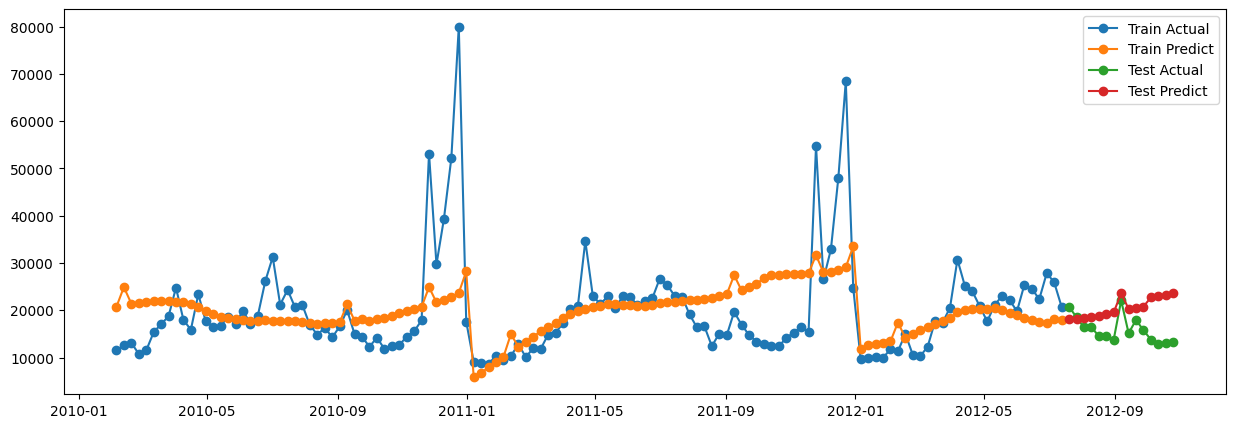

In [15]:
# Plot actual vs. predict results
plt.figure(figsize=(15,5))
axes = plt.axes()
axes.plot(y_train.index, y_train, marker='o', label="Train Actual")
axes.plot(y_train.index, y_train_pred, marker='o', label="Train Predict")
axes.plot(y_test.index, y_test, marker='o', label="Test Actual")
axes.plot(y_test.index, y_test_pred, marker='o', label="Test Predict")
axes.legend()
plt.show()

In [16]:
# Evaluate model

mlr_mae = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mlr_mae:.4f}")

mlr_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
print(f"MAPE: {mlr_mape:.4f}%")

mlr_smape = smape(y_test, y_test_pred)
print(f"SMAPE: {mlr_smape:.4f}%")

mlr_mse = mean_squared_error(y_test, y_test_pred)
print(f"MSE: {mlr_mse:.4f}")

mlr_rmse = np.sqrt(mlr_mse)
print(f"RMSE: {mlr_rmse:.4f}")

mlr_r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared: {mlr_r2:.4f}")

MAE: 5035.0428
MAPE: 35.2171%
SMAPE: 28.0099%
MSE: 36145251.5922
RMSE: 6012.0921
R-Squared: 0.1892


**Interpretation:**

For the selected store 17 and department 7:

- R-squared was about 0.1892, meaning only 18.92% of the variation of the response can be explained by the MLR model, suggesting poor performance of the MLR model on this dataset.
- RMSE and MAE were quite large. For one reason, the weekly sales values are large numbers, even some relatively small amount of difference can cause large error. But since the model does not perform well, it is reasonable to see large errors.
- MAPE and SMAPE are around 35% and 28% respectively, suggesting a high error rate.

In conclusion, the linear model did not perform well. So, I will try other methods.

The prediction result will be different if selecting different store and department. Change the n_store and n_dept at the beginning of section 2, then re-run all the code below to explore more.


### **4. ARIMA**

To perform ARIMA model, we need to extract the response features from the dataset.

In [17]:
# Extract weekly sales only
df_ts = df[['Weekly_Sales']]

# Split train-test in 90:10 ratio
train_ts, test_ts = df_ts[0:int(len(df_ts)*0.9)], df_ts[int(len(df_ts)*0.9):]
print(f"Train data shape: {train_ts.shape}")
print(f"Test data shape: {test_ts.shape}")

Train data shape: (128, 1)
Test data shape: (15, 1)


#### **4.1. Perform Augmented Dickey-Fuller test**

ref: https://developer.ibm.com/tutorials/awb-arima-models-in-python/#step-6-train-the-arima-model7 \
Assuming the null hypothesis be the dataset is non-stationary.

In [18]:
#
adf_result = adfuller(df_ts)
print(f'p-value: {adf_result[1]}')

p-value: 4.5068692987772497e-07


Since p-value < 0.05, the null hypothesis could be rejected. \
Thus, it suggests that the data is stationary. In ARIMA, d order can be set as 0.


#### **4.2. Perform Auto ARIMA for hyperparameter tuning**

ref: https://blog.devgenius.io/finding-optimal-p-d-and-q-values-for-your-arima-model-94669a909a35

In [19]:
model = auto_arima(train_ts['Weekly_Sales'], start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=0,   # data is already stationary.
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2702.712, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2744.693, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2700.707, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2714.767, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2932.181, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2702.674, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2704.691, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2726.033, Time=0.22 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.980 seconds


#### **4.3. Fit and Predict with ARIMA model**

ref: https://developer.ibm.com/tutorials/awb-arima-models-in-python/#step-6-train-the-arima-model7

In [20]:
def build_arima(train_ts, test_ts, order=(1,0,0)):
    # Initialize variables
    # history sales
    y_train_ts = train_ts["Weekly_Sales"].tolist()
    # actual sales
    y_test_ts = test_ts["Weekly_Sales"].tolist()
    # predicted sales
    y_pred_ts = []

    for i in range(0, len(y_test_ts)):
        # predict
        # Try 0, 1, 2 for d order, it turns out set d as 2 could lead to the least error in result.
        arima_model = ARIMA(y_train_ts, order=order).fit()
        yhat = arima_model.forecast()[0]
        # invert transformed prediction
        y_pred_ts.append(yhat)
        # observation
        obs = y_test_ts[i]
        y_train_ts.append(obs)

    return y_test_ts, y_pred_ts

y_test_ts, y_pred_ts = build_arima(train_ts, test_ts, order=(1,0,0))

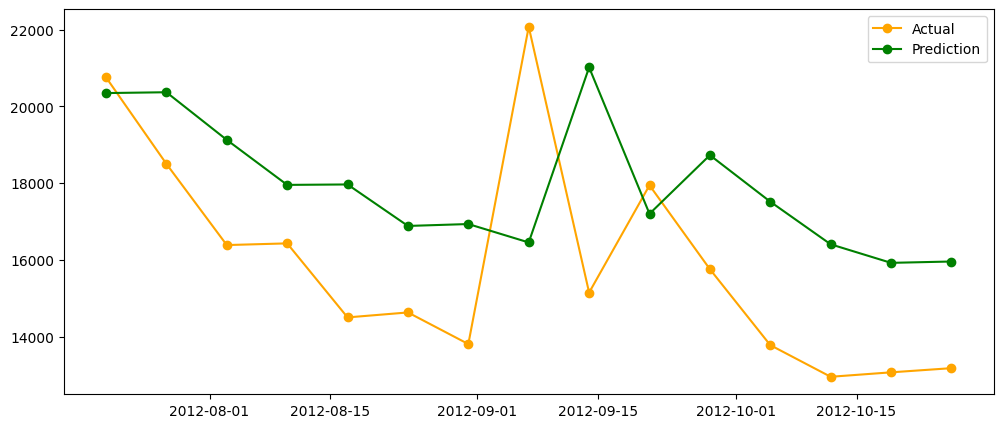

In [21]:
# Plot actual vs. predicted test data
plt.figure(figsize=(12,5))
axes = plt.axes()
axes.plot(test_ts.index, y_test_ts, marker='o', color='orange', label='Actual')
axes.plot(test_ts.index, y_pred_ts, marker='o', color='green', label='Prediction')
axes.legend()
plt.show()

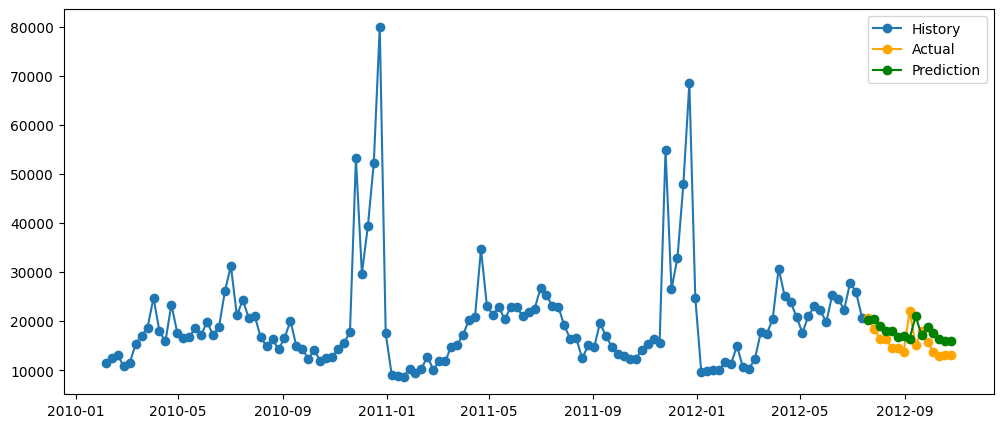

In [22]:
# Plot training (history), test (actual), and predicted data
plt.figure(figsize=(12,5))
axes = plt.axes()
axes.plot(train_ts.index, train_ts.iloc[:, 0], marker='o', label='History')
axes.plot(test_ts.index, y_test_ts, marker='o', color='orange', label='Actual')
axes.plot(test_ts.index, y_pred_ts, marker='o', color='green', label='Prediction')
axes.legend()
plt.show()

In [23]:
# Evaluate model

arima_mae = mean_absolute_error(y_test_ts, y_pred_ts)
print(f"MAE: {arima_mae:.4f}")

arima_mape = mean_absolute_percentage_error(y_test_ts, y_pred_ts) * 100
print(f"MAPE: {arima_mape:.4f}%")

arima_smape = smape(y_test_ts, y_pred_ts)
print(f"SMAPE: {arima_smape:.4f}%")

arima_mse = mean_squared_error(y_test_ts, y_pred_ts)
print(f"MSE: {arima_mse:.4f}")

arima_rmse = np.sqrt(arima_mse)
print(f"RMSE: {arima_rmse:.4f}")

MAE: 2893.4832
MAPE: 18.9203%
SMAPE: 17.4038%
MSE: 10495505.2151
RMSE: 3239.6767


MAE, MSE, RMSE are large numbers because the weekly sales values are large. \
MAPE and SMAPE suggests the model have error rate about 18%, significantly lower than linear regression.

#### **4.4. Another method of hyperparameter tuning: Cross Validation**

In previous step, I use auto arima and its build-in metric AIC to choose the best order (p, q, d) for ARIMA model. In this section, I will use Cross Validation to choose (p, q, d). I would like to see if the result would be same.

In [24]:
# Assuming p and q are within [0, 1, 2, 3] and d is within [0, 1, 2]
# Generate all possible combinations
ps = [0, 1, 2, 3]
ds = [0, 1, 2]
qs = [0, 1, 2, 3]

combos = []

for p in ps:
    for d in ds:
        for q in qs:
            combos.append((p, d, q))
print(f"Total number of combinations: {len(combos)}")

Total number of combinations: 48


In [25]:
# Perform 5-fold cross validation for each combination

warnings.simplefilter('ignore', UserWarning)

average_mape_df = pd.DataFrame(columns=['combo', 'avg_mape'])

for combo in combos:
    # Set number of folds
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize lists to store evaluation metrics
    mape_scores = []

    # Fit and predict
    for train_index, test_index in tscv.split(df_ts):
        train_data, test_data = df_ts.iloc[train_index], df_ts.iloc[test_index]
        model = ARIMA(train_data, order=combo).fit()
        predictions = model.forecast(steps=len(test_data))

        # Calculate MAPE
        mape_cur = mean_absolute_percentage_error(test_data, predictions) * 100
        mape_scores.append(mape_cur)

    # Calculate average MAPE
    average_mape = np.mean(mape_scores)
    average_mape_df = average_mape_df._append({'combo': combo, 'avg_mape': average_mape}, ignore_index=True)

average_mape_df

,combo,avg_mape
0,"(0, 0, 0)",36.364153
1,"(0, 0, 1)",35.836103
2,"(0, 0, 2)",35.200416
3,"(0, 0, 3)",36.088199
4,"(0, 1, 0)",58.662106
5,"(0, 1, 1)",54.261608
6,"(0, 1, 2)",51.930196
7,"(0, 1, 3)",34.594611
8,"(0, 2, 0)",261.700684
9,"(0, 2, 1)",69.588529


In [26]:
min_avg_mape = min(average_mape_df["avg_mape"])
average_mape_df[average_mape_df["avg_mape"] == min_avg_mape]

,combo,avg_mape
38,"(3, 0, 2)",30.881678


**With cross validation, the best order of ARIMA model should be (3, 0, 2). Let's see how it performs on test data.**

In [27]:
# Fit and predict
y_test_ts, y_pred_ts = build_arima(train_ts, test_ts, order=(3,0,2))

# Evaluate model

arima_mae = mean_absolute_error(y_test_ts, y_pred_ts)
print(f"MAE: {arima_mae:.4f}")

arima_mape = mean_absolute_percentage_error(y_test_ts, y_pred_ts) * 100
print(f"MAPE: {arima_mape:.4f}%")

arima_smape = smape(y_test_ts, y_pred_ts)
print(f"SMAPE: {arima_smape:.4f}%")

arima_mse = mean_squared_error(y_test_ts, y_pred_ts)
print(f"MSE: {arima_mse:.4f}")

arima_rmse = np.sqrt(arima_mse)
print(f"RMSE: {arima_rmse:.4f}")

MAE: 2473.1485
MAPE: 15.5256%
SMAPE: 15.0213%
MSE: 9400121.9991
RMSE: 3065.9618


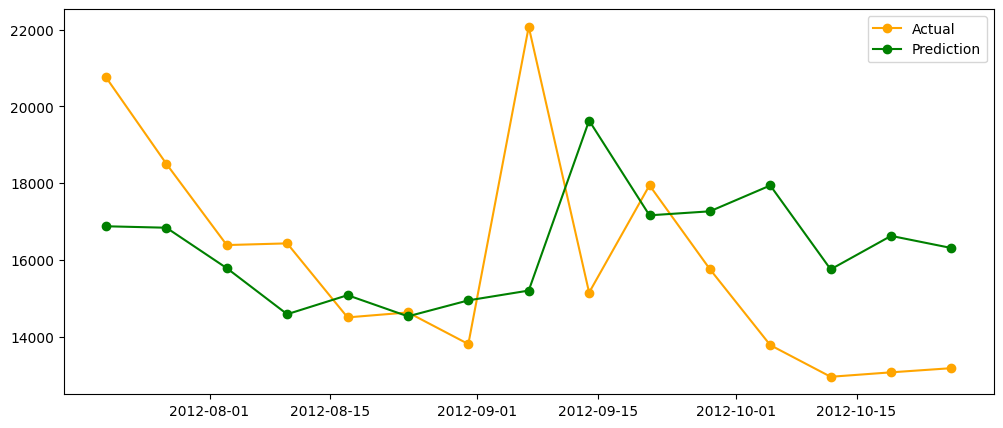

In [28]:
# Plot actual vs. predicted test data
plt.figure(figsize=(12,5))
axes = plt.axes()
axes.plot(test_ts.index, y_test_ts, marker='o', color='orange', label='Actual')
axes.plot(test_ts.index, y_pred_ts, marker='o', color='green', label='Prediction')
axes.legend()
plt.show()

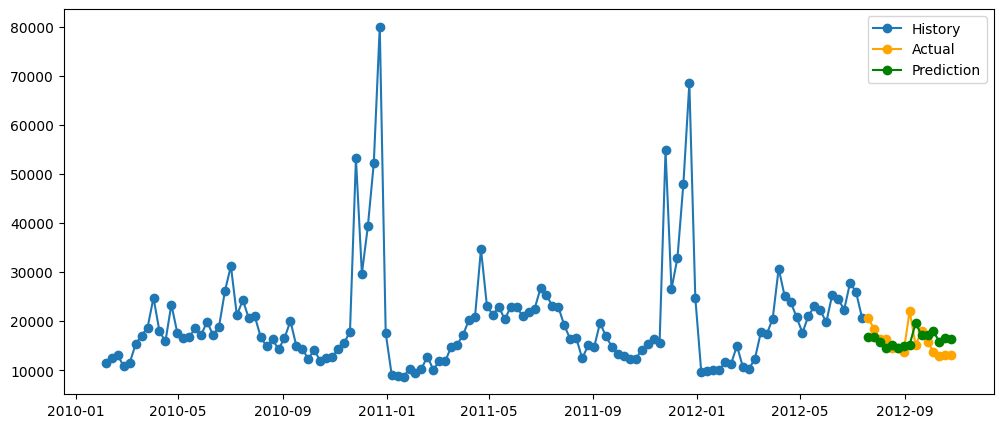

In [29]:
# Plot training (history), test (actual), and predicted data
plt.figure(figsize=(12,5))
axes = plt.axes()
axes.plot(train_ts.index, train_ts.iloc[:, 0], marker='o', label='History')
axes.plot(test_ts.index, y_test_ts, marker='o', color='orange', label='Actual')
axes.plot(test_ts.index, y_pred_ts, marker='o', color='green', label='Prediction')
axes.legend()
plt.show()

### **5. Summary**

- **Steps I have taken**
    - Loaded and examined the data from previous notebook.
    - Splitted the dataset into train and test set.
    - Performed feature selection for multiple linear regression. Then fit, predicted, and evaluated the model.
    - Performed ADF test and auto arima for parameters selection of ARIMA model. Then fit, predicted, and evaluated the model.
    - Performed cross validation on parameters selection for another ARIMA model. Then fit, predicted, and evaluated the new model.
    - Visualization of model prediction results.

- **Results**
    - **Multiple Linear Regression**
        - Chose the top 4 features for modeling: Year, IsHoliday, CPI, Unemployment
        - Coefficients:
            - Year: -19476.4345
            - IsHoliday: 3723.5897
            - CPI: 7939.2845
            - Unemployment: -4053.2594
        - Interceptor: 38191051.8778
        - Evaluation:
            - MAE 5035.0428
            - MAPE: 35.2171%
            - SMAPE: 28.0099%
            - MSE: 36145251.5922
            - RMSE: 6012.0921
            - R-Squared: 0.1892
    
    - **ARIMA**
        - ADF test: the data was stationary, so d was set as 0.
        - Auto arima for tuning: (p=1, d=0, q=0) led to best AIC.
            - Results with this setting:
                - MAE: 2893.4832
                - MAPE: 18.9203%
                - SMAPE: 17.4038%
                - MSE: 10495505.2151
                - RMSE: 3239.6767
        - Cross validation for tuning: (p=3, d=0, q=2) led to the least error rate.
            - Results with this setting:
                - MAE: 2473.1485
                - MAPE: 15.5256%
                - SMAPE: 15.0213%
                - MSE: 9400121.9991
                - RMSE: 3065.9618

- **Interest Findings**
    - For MLR:
        - R-squared is just less than 19%, bad performance for the linear model. Apparently, the dataset is not linear correlated through plotting.
        - MAPE and SMAPE are about 1/3, not good.
        - RMSE and MAE were quite large, maybe because the values of weekly sales are large number. A small percent of error could led to large error value.
        - Most of the coefficients of the features are reasonable. For example, Unemployment rate is negatively related with weekly sales. Less people umemployed, the better the sales will be. What is interesting is Year is also negatively related. It may due to various reasons, but the trend is not good for a store.

    - For ARIMA:
        - ARIMA performs better than linear regression, reducing the error and capturing the trend in a better way.
        - Auto arima and cross validation led to different tuning results. Cross validation led to better performance than auto arima. But auto arima is the suggested methods. One reason is because auto arima uses a build-in metric AIC to measure the performance, while cross validation is more customizable. AIC and MAPE might calculate in a different way.
        - For cross validation, we need to set the scope of the target parameter. Since there might be better results out of the set scope, the result we get might be just a local best solution instead of a global one.